## Accelerate Inference: Neural Network Pruning

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow.keras.layers import *

print(tf.version.VERSION)

2.15.0


In [2]:
# untar
!ls
!tar -xvzf dataset.tar.gz
# load train
train_images = pickle.load(open('train_images.pkl', 'rb'))
train_labels = pickle.load(open('train_labels.pkl', 'rb'))
# load val
val_images = pickle.load(open('val_images.pkl', 'rb'))
val_labels = pickle.load(open('val_labels.pkl', 'rb'))

dataset.tar.gz	sample_data
train_images.pkl

gzip: stdin: unexpected end of file
tar: Unexpected EOF in archive
tar: Unexpected EOF in archive
tar: Error is not recoverable: exiting now


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-79c677a4a467>", line 5, in <cell line: 5>
    train_images = pickle.load(open('train_images.pkl', 'rb'))
_pickle.UnpicklingError: pickle data was truncated

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'UnpicklingError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/u

TypeError: object of type 'NoneType' has no len()

In [ ]:
# Define the neural network architecture (don't change this)

model = models.Sequential()
model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-5), input_shape=(25,25,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(1e-5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-5)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(1e-5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 25, 32)        896       
                                                                 
 activation (Activation)     (None, 25, 25, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 23, 23, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 11, 11, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 11, 11, 32)        0         
                                                        

In [ ]:
# you can use the default hyper-parameters for training,
# val accuracy ~72% after 50 epochs

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001, weight_decay=1e-6),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, batch_size=32, epochs=50,
                    validation_data=(val_images, val_labels)) # train for 50 epochs, with batch size 32

703/703 [==============================] - 16s 8ms/step - loss: 1.5172 - accuracy: 0.3100 - val_loss: 1.3676 - val_accuracy: 0.4051
Epoch 2/50
703/703 [==============================] - 4s 6ms/step - loss: 1.3546 - accuracy: 0.4160 - val_loss: 1.3484 - val_accuracy: 0.4345
Epoch 3/50
703/703 [==============================] - 4s 5ms/step - loss: 1.2918 - accuracy: 0.4539 - val_loss: 1.2313 - val_accuracy: 0.4745
Epoch 4/50
703/703 [==============================] - 4s 6ms/step - loss: 1.2506 - accuracy: 0.4778 - val_loss: 1.1825 - val_accuracy: 0.5156
Epoch 5/50
703/703 [==============================] - 4s 6ms/step - loss: 1.2113 - accuracy: 0.5021 - val_loss: 1.1466 - val_accuracy: 0.5303
Epoch 6/50
703/703 [==============================] - 4s 6ms/step - loss: 1.1826 - accuracy: 0.5161 - val_loss: 1.1489 - val_accuracy: 0.5137
Epoch 7/50
703/703 [==============================] - 4s 6ms/step - loss: 1.1453 - accuracy: 0.5352 - val_loss: 1.0856 - val_accuracy: 0.5533
Epoch 8/50
703/7

In [ ]:
original_weights = model.get_weights()
results = model.evaluate(val_images, val_labels, batch_size=128)

20/20 [==============================] - 1s 13ms/step - loss: 0.7441 - accuracy: 0.7137


In [ ]:
class Pruner:
  def __init__(self, model):
    self.model = model
    self.layers = model.get_weights()

  def get_threshold(self, prune_rate):
    all_weights = tf.cast(tf.convert_to_tensor([]), dtype=tf.float32)
    # for each layer, flatten tensor and append
    for weights in self.layers:
      # flatten the tensor
      new_weights = tf.cast(tf.reshape(weights, [-1]), dtype=tf.float32)
      all_weights = tf.concat([new_weights, all_weights], 0)

    # get the threshold at prune_rate of weights
    abs_weights = tf.math.abs(all_weights)
    threshold = np.percentile(abs_weights, prune_rate)

    self.total_parameters = np.shape(all_weights.numpy())[0]
    self.threshold = threshold


  def prune(self, prune_rate):
    self.get_threshold(prune_rate)
    new_weights = []
    masks = []

    # for each layer
    num_one_weights = 0
    for weights in self.layers:
      # set layer.mask to the mask
      greater_weights = tf.cast(tf.math.greater(tf.math.abs(weights), self.threshold), dtype=tf.float32)
      layer_mask = tf.math.multiply(greater_weights, weights)
      new_weights.append(layer_mask)
      masks.append(greater_weights)
      num_one_weights += np.sum(greater_weights.numpy())

    self.weights = new_weights
    self.masks = masks
    self.num_zero_weights = self.total_parameters - num_one_weights


  def fine_tune(self):
    """
    training loop adapted from keras documentation:
    https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch
    """

    # Instantiate an optimizer.
    optimizer = keras.optimizers.Adam(learning_rate=1e-6, weight_decay=1e-8)
    # Instantiate a loss function.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

    # Prepare the training dataset.
    batch_size = 32
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

    # Prepare the validation dataset.
    val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
    val_dataset = val_dataset.batch(batch_size)

    # Prepare the metrics.
    train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

    epochs = 20
    for epoch in range(epochs):
      # Iterate over the batches of the dataset.
      for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:
            # Run the forward pass of the layer. The operations that the layer applies
            # to its inputs are going to be recorded on the GradientTape.
            logits = self.model(x_batch_train, training=True)  # Logits for this minibatch
            # Compute the loss value for this minibatch.
            loss_value = loss_fn(y_batch_train, logits)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, self.model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, self.model.trainable_weights))


      # add masks to the trainable_weights
      pre_masked_weights = self.model.get_weights()
      masked_weights = []
      for i in range(len(pre_masked_weights)):
        weight = pre_masked_weights[i]
        mask = self.masks[i]
        masked_weights.append(tf.math.multiply(weight, mask))

      self.weights = masked_weights
      self.model.set_weights(self.weights)

      # Run a validation loop at the end of each epoch.
      for x_batch_val, y_batch_val in val_dataset:
          val_logits = model(x_batch_val, training=False)
          # Update val metrics
          val_acc_metric.update_state(y_batch_val, val_logits)
      val_acc = val_acc_metric.result()
      val_acc_metric.reset_states()
      print("Epoch %d" % (epoch,), "Validation acc: %.4f" % (float(val_acc),))


    # count number of zero weights for each layer at the end of all training
    num_zero_weights = 0
    for weights in self.weights:
      zero_weights = tf.cast(tf.math.equal(weights, 0.0), dtype=tf.float32)
      num_zero_weights += np.sum(zero_weights.numpy())
    self.num_zero_weights = num_zero_weights
    print("sparsity:", self.num_zero_weights/self.total_parameters)


In [ ]:
def test_pruning(prune_rate):
  # reset the model weights to the original values
  model.set_weights(original_weights)

  # create the pruner, prune, set weights
  pruner = Pruner(model)
  pruner.prune(prune_rate)
  model.set_weights(pruner.weights)
  pruner.fine_tune()
  model.set_weights(pruner.weights)

  # evaluate final model and get the accuracy
  results = model.evaluate(val_images, val_labels, batch_size=128)
  accuracy = results[1]

  # get the pruning score
  if accuracy > 0.6 and prune_rate > 0:
    return (accuracy + pruner.num_zero_weights / pruner.total_parameters) / 2, pruner.weights
  else:
    return 0, pruner.weights


In [ ]:
# new_finetune_tests = [10, 20, 30, 40, 50, 60, 70, 80, 90]
new_finetune_tests = [70]
for rate in new_finetune_tests:
  score_metric, finetune_weights = test_pruning(rate)
  model.set_weights(finetune_weights)
  print("\n---post fine-tuning---\n")
  print("best score:", score_metric, "\nbest prune rate:", rate)

Epoch 0 Validation acc: 0.4903
Epoch 1 Validation acc: 0.5291
Epoch 2 Validation acc: 0.5596
Epoch 3 Validation acc: 0.5794
Epoch 4 Validation acc: 0.5972
Epoch 5 Validation acc: 0.6087
Epoch 6 Validation acc: 0.6119
Epoch 7 Validation acc: 0.6206
Epoch 8 Validation acc: 0.6261
Epoch 9 Validation acc: 0.6285
Epoch 10 Validation acc: 0.6341
Epoch 11 Validation acc: 0.6345
Epoch 12 Validation acc: 0.6364
Epoch 13 Validation acc: 0.6380
Epoch 14 Validation acc: 0.6392
Epoch 15 Validation acc: 0.6444
Epoch 16 Validation acc: 0.6467
Epoch 17 Validation acc: 0.6495
Epoch 18 Validation acc: 0.6507
Epoch 19 Validation acc: 0.6527
sparsity: 0.6999998313468807
20/20 [==============================] - 0s 4ms/step - loss: 0.8922 - accuracy: 0.6527

---post fine-tuning---

best score: 0.6763365379115995 
best prune rate: 70


In [ ]:
# you need to save the model's weights, naming it 'my_model_weights.h5'
model.save_weights("my_model_weights_mag.h5")

# running this cell will immediately download a file called 'my_model_weights.h5'
from google.colab import files
files.download("my_model_weights_mag.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

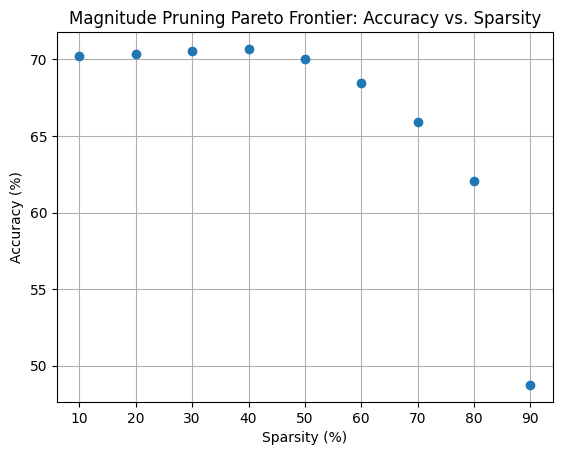

In [ ]:
# pareto frontier plot
import matplotlib.pyplot as plt
import numpy as np

# define data values
x = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90])  # X-axis points
y = np.array([0.7026, 0.7038, 0.7057, 0.7069, 0.7006, 0.6848, 0.6590, 0.6206, 0.4875]) * 100
plt.xlabel("Sparsity (%)")
plt.ylabel("Accuracy (%)")
plt.title("Magnitude Pruning Pareto Frontier: Accuracy vs. Sparsity")

plt.plot(x, y, 'o')  # Plot the chart
plt.grid()
plt.show()  # display